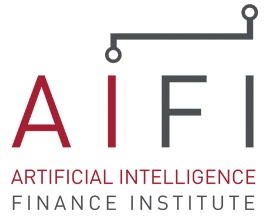


# Bootcamp - Python and Coding - Primer: Actors

# About this Notebook


This notebook covers the Actor Model, using the [Pykka libray](https://pykka.readthedocs.io/en/stable/). The Actor Model is a conceptual model to deal with concurrent computation. It defines some general rules for how the system's components should behave and interact with each other. The fundamental unit of computation in the Actor Model is an Actor - an entity that can make local decisions, create more actors, send more messages, and determine how to respond to the next message received.

<br>



The Actor Model is beneficial for handling concurrent tasks in a way that can avoid many of the common issues that come with multithreaded programming. For example, it avoids race conditions, as actors process messages one at a time and don't share state with other actors. It is also naturally distributed, as actors only communicate via messages, so they can easily be spread out across multiple machines or cores.

<br>


In a __finance context__, actors can be used to __model various independent entities__ (like trading agents) that __communicate__ with each other __through messages__ (like buy/sell orders). It's a natural model for many financial systems and can help make these systems more robust and easier to reason about.

# Global Interpreter Lock

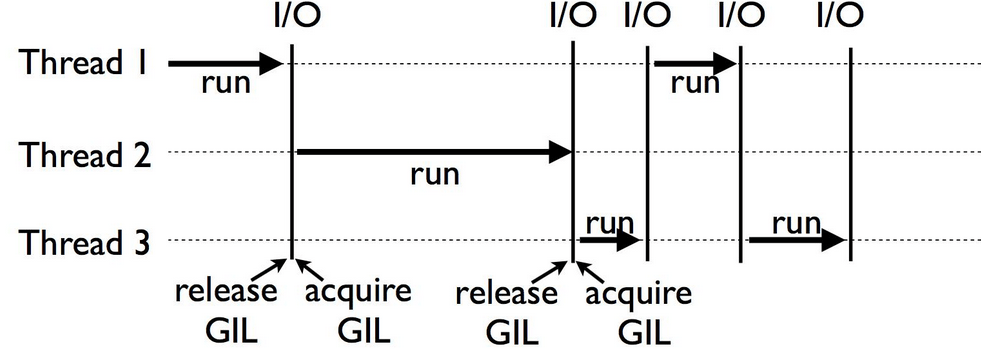

The Global Interpreter Lock (GIL) is a mechanism used in the CPython interpreter of Python to synchronize the execution of threads so that only one native thread can execute at a time within a single process. This means that even though Python supports multi-threading, in most cases, it doesn't allow true parallel execution of tasks because of the GIL.

However, Pykka or Ray sidesteps the GIL by using multiple processes instead of threads. Each actor runs in its own process, and these processes can execute in parallel. Moreover, actors can be distributed across multiple machines in a cluster, enabling even greater parallelism. This is particularly important for computationally-intensive tasks like machine learning.

# Actors

## Communication in actor systems

Actors communicate only by message passing
- Messages are sent asynchronously
- No shared mutable state between actors! (Share nothing concurrency)
- Messages must have "send by value" semantics (immutable)

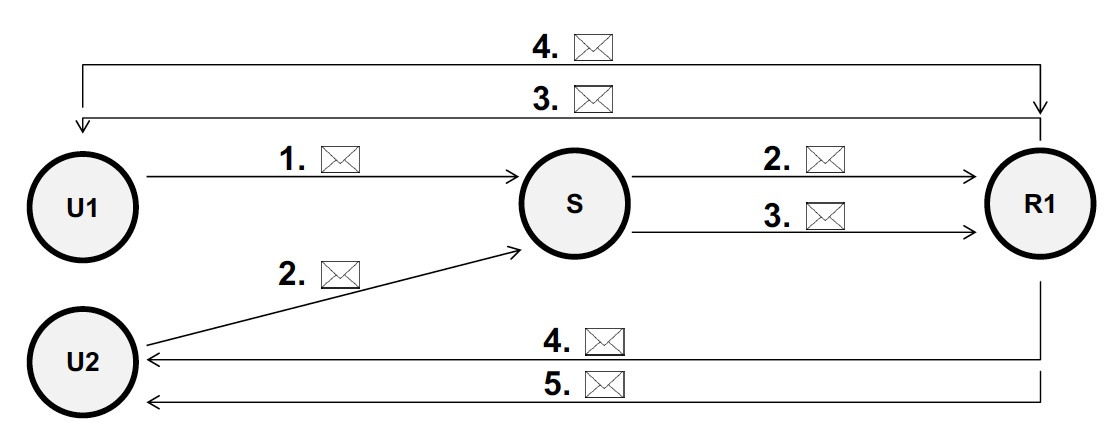

## Anatomy of an actor

Actor =

- Independent control +
- Encapsulated state +
- Behavior +
- Mailbox

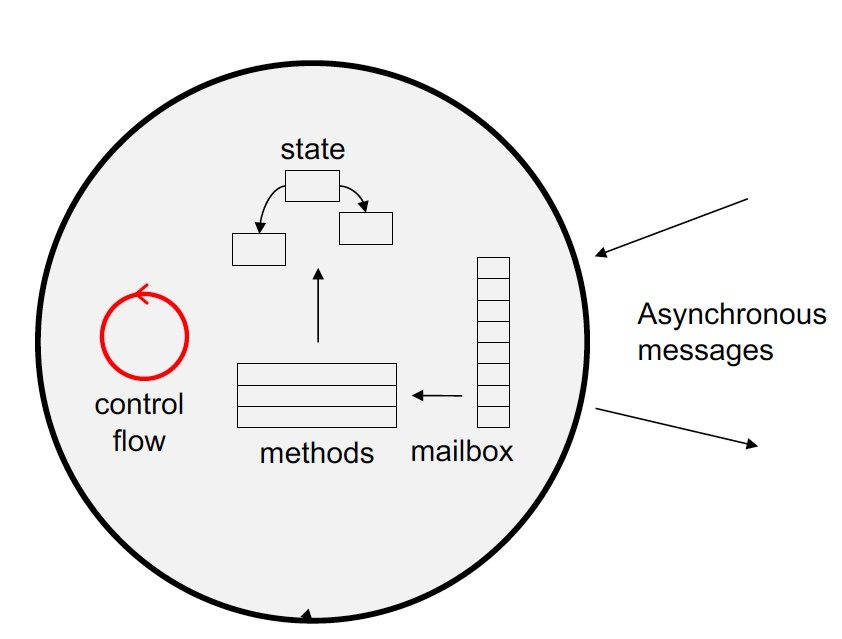

# Imports

In [ ]:
import yfinance as yf
import pykka
import time
from multiprocessing import Process, Pipe

In [ ]:
class PrintMsg:
    __match_args__ = ("msg",)
    def __init__(self, msg: str):
        self.msg = msg

class ShoutMsg:
    __match_args__ = ("msg",)
    def __init__(self, msg: str):
        self.msg = msg

class Terminate:
    pass

In [ ]:
def actor_function(pipe):
    while True:
        msg = pipe.recv()
        match msg:
            case PrintMsg(m):
                print("received:", m)
            case ShoutMsg(m):
                print("RECEIVED:", m.upper())
            case Terminate():
                return
            case _:
                print("Unknown message:", msg)

In [8]:
parent_conn, child_conn = Pipe()
p = Process(target=actor_function, args=(child_conn,))
p.start()

parent_conn.send(PrintMsg("Hello, World!"))
parent_conn.send(ShoutMsg("Hello, World!"))
parent_conn.send("Unexpected message")

parent_conn.send(Terminate()) # Terminate the instance

p.join()


received: Hello, World!
RECEIVED: HELLO, WORLD!
Unknown message: Unexpected message


### Now let's break down the Python code

- __Define Message Classes__: The `PrintMsg`, `ShoutMsg`, and `Terminate` classes are simple data classes designed to carry information. They're the "messages" that can be sent to the actor. The `__match_args__` is a special attribute used by Python's pattern matching mechanism to destructure the instance.

 - PrintMsg and ShoutMsg carry a string message.
 - Terminate doesn't carry any information; it's simply a signal that the actor should stop running.


- __Actor Function__: The `actor_function` is where the "actor" behavior is defined. It continuously listens for incoming messages and, depending on the type of message, performs different actions.

  - If it receives a `PrintMsg`, it prints the message with "received:" in front.
  - If it receives a `ShoutMsg`, it prints the message in uppercase with "RECEIVED:" in front.
  - If it receives a `Terminate` message, it returns, effectively terminating the process.
  - If it receives any other type of message, it prints "Unknown message:" with the unexpected message.

- __Main Process__: The main part of the script is where the actor (i.e., the actor_function) is started as a separate process, and messages are sent to it.

  - First, a multiprocessing `Pipe` is created. This sets up a communication channel between the parent and child processes.
  - Then, a child process is started with `actor_function` as the target function and the one end of the pipe (`child_conn`) as the argument.
  - Next, the parent process sends several messages through the other end of the pipe (`parent_conn`), including a Terminate message.
  - Finally, it waits for the child process to finish by calling `p.join()`.

## Pykka library

 Pykka is a Python implementation of the actor model, which is the same model that the Akka library for Scala is based on. A practical example would be to use it in a finance application for managing a portfolio with changing prices.

In the actor model, each "actor" is an independent entity that communicates with other actors solely through message passing. This can be a very effective way to handle concurrent tasks, such as tracking changing prices in multiple parts of a portfolio.

Here's an example of how you might structure this with Pykka:

In [1]:
%%capture
!pip install pykka

In the following example, the PortfolioActor manages a dictionary of prices. It accepts messages to update or get the price for a particular symbol. In a real-world application, you'd likely have additional actors for fetching prices from a data source and updating the portfolio actor accordingly. Here we introduce the concept of a CustomerActor that could represent a customer like Elon, who has a portfolio of stocks. In this example, the CustomerActor would hold a reference to a PortfolioActor, which in turn fetches prices through a PriceFetchingActor.

In [ ]:
class PriceFetchingActor(pykka.ThreadingActor):
    def fetch_price(self, symbol):
        ticker = yf.Ticker(symbol)
        return ticker.info['regularMarketPrice']


In [ ]:
class PortfolioActor(pykka.ThreadingActor):
    def __init__(self, initial_prices):
        super().__init__()
        self.prices = initial_prices
        self.price_fetcher = PriceFetchingActor.start()

    def update(self):
        for stock in self.prices:
            new_price = self.price_fetcher.fetch_price(stock)
            print(f'Updated price of {stock} from {self.prices[stock]} to {new_price}')
            self.prices[stock] = new_price

    def get_portfolio_value(self):
        return sum(self.prices.values())

    def get_state(self):
        return self.prices.copy()

In [ ]:
class CustomerActor(pykka.ThreadingActor):
    def __init__(self, name, portfolio):
        super().__init__()
        self.name = name
        self.portfolio = portfolio

    def update_portfolio(self):
        print(f'{self.name} is updating portfolio...')
        self.portfolio.update()

    def get_portfolio_value(self):
        return self.portfolio.get_portfolio_value()

In [23]:
portfolio_actor = PortfolioActor.start({'AAPL': 150.0, 'GOOG': 2500.0})

elon = CustomerActor.start('Elon', portfolio_actor.proxy())
elon_proxy = elon.proxy()

# Update portfolio prices every 5 seconds
for _ in range(3):
    elon_proxy.update_portfolio().get()  # call and block until method finishes
    time.sleep(5)

# Get the portfolio value
portfolio_value_future = elon_proxy.get_portfolio_value()
# block until the method finishes and get the result
portfolio_value = portfolio_value_future.get()  

print(f"\nElon's portfolio value: {portfolio_value}")

portfolio_state = portfolio_actor.proxy().get_state().get()
print(f"\nElon's portfolio state: {portfolio_state}")

elon.stop()
portfolio_actor.stop()


Elon is updating portfolio...
Elon is updating portfolio...
Elon is updating portfolio...

Elon's portfolio value: <pykka._threading.ThreadingFuture object at 0x7f9d380c61d0>

Elon's portfolio state: {'AAPL': 150.0, 'GOOG': 2500.0}


True

This script does the following:

- It starts a PortfolioActor with some initial prices for 'AAPL' and 'GOOG'.
- It starts a CustomerActor (Elon) with a reference to the portfolio actor.
- Every 5 seconds, Elon asks the portfolio actor to update its stock prices. This triggers the portfolio actor to fetch the latest prices from the PriceFetchingActor.
- After three updates, it prints out the total portfolio value and the final state of the portfolio.

You should see the portfolio being updated in real-time and the final portfolio value should reflect the latest stock prices. The output gives you a step-by-step understanding of how the actor model works in Pykka, showcasing actor interactions, asynchronous messaging, and the encapsulation of state in actors.

Please note that this is a simple example and does not include considerations such as error handling for potential issues (network errors, invalid symbols, etc.), nor does it consider the real delay between subsequent calls required by Yahoo's policies.

## Actors as finite state machines



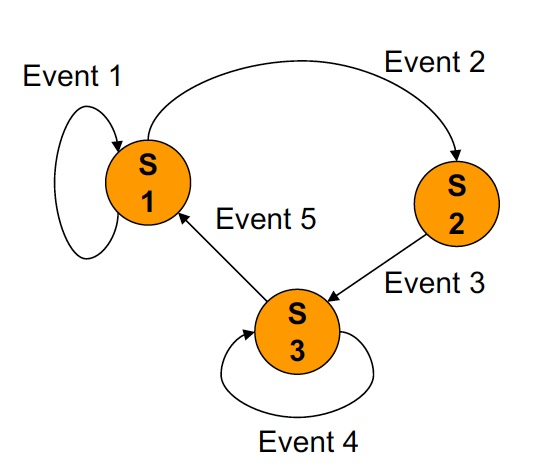

## Finite State Machine (FSM)

- Consists of a number of states
- State changes are triggered by events

Some reasons why actors together with finate state machines can be quite beneficial in the finance sector:  

- __Concurrency and Parallelism__: Financial systems often deal with a large volume of data that needs to be processed concurrently. The actor model provides a structure for handling multiple requests at the same time. Each actor can process its own set of messages independently, allowing for parallel processing and thus a potential speedup in overall execution time.

- __Fault Tolerance__: The actor model has inherent fault tolerance, as each actor operates independently of the others. If one actor fails, it doesn't affect the operation of other actors. This is crucial in financial systems where system crashes could result in significant financial loss.


- __State Management__: Financial transactions often involve complex state management (e.g., the stages of a multi-part transaction). Using finite state machines within actors can help manage these complex states in a controlled and reliable manner. Transitions between states are explicit and easy to understand, and incorrect transitions can be caught and handled appropriately.

- __Immutable Messages__: In finance, ensuring data integrity is critical. The actor model promotes the use of immutable messages, which can prevent a range of bugs and errors related to shared mutable state.

- __Real-Time Systems__: Financial systems often need to handle high-frequency data in real-time. The actor model, with its asynchronous communication, can be a good fit for such systems, as it can handle a large number of messages and process them concurrently.


- __Scalability__: The actor model can easily be distributed across multiple machines or cores, which makes it a good fit for scalable financial systems.

- __Encapsulation__: Each actor in the actor model encapsulates its state and behavior, similar to an object in object-oriented programming. This helps in managing complexity and maintaining large systems, as each actor can be understood in isolation.

In summary, the combination of Pykka's actor model and finite state machines provides a framework that allows for handling complex, concurrent operations in a clear and robust way, which is crucial in finance where accuracy, reliability, and performance are paramount.

In [ ]:
class MyActor(pykka.ThreadingActor):
    def __init__(self):
        super().__init__()
        self.state = 'State1'
        print(f'Initial state: {self.state}')

    def on_receive(self, message):
        if self.state == 'State1':
            if message.get('event') == 'event1':
                self.state = 'State2'
            elif message.get('event') == 'event2':
                self.state = 'State3'
        elif self.state == 'State2':
            if message.get('event') == 'event3':
                self.state = 'State1'

        print(f'Transitioned to: {self.state}')

In [3]:
# Create actor
actor_ref = MyActor.start()

# Send events
actor_ref.tell({'event': 'event1'})
actor_ref.tell({'event': 'event3'})
actor_ref.tell({'event': 'event2'})

# Stop actor
pykka.ActorRegistry.stop_all()


Initial state: State1
Transitioned to: State2
Transitioned to: State1
Transitioned to: State3


[True]

In the code above, we're creating an instance of MyActor, then sending it three events. After each event is processed, the actor will log its new state to the console. At the end, we stop the actor.



Keep in mind that Pykka actors process messages asynchronously, which means that if you send multiple messages in quick succession, there's no guarantee about the order in which they'll be processed. In a real-world application, you'd probably want to add some sort of acknowledgement mechanism to ensure that events are processed in the correct order.

Also, note that stopping all actors with pykka.ActorRegistry.stop_all() will block until all actors have finished processing their current message. If there are more messages in their mailbox, those messages will not be processed.